<a href="https://colab.research.google.com/github/alwanfa/neural-network-exploration/blob/main/self_CodeChallenge_WeightPerformanceBasedOnSTDDIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COURSE: A deep understanding of deep learning
## SECTION: Weight inits and investigations
### LECTURE: A surprising demonstration of weight initializations
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [ ]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Import and process the data

In [ ]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

In [ ]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# Create the DL model

In [ ]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)

      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)

  # create the model instance
  net = mnistNet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.01)

  return net,lossfun,optimizer

# Explore the weights

In [ ]:
tmpnet = createTheMNISTNet()[0]
print(tmpnet)

print('\n\nWeights for layer fc1:')
print(tmpnet.fc1.weight.data)

mnistNet(
  (input): Linear(in_features=784, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)


Weights for layer fc1:
tensor([[-0.1157, -0.0259,  0.1009,  ...,  0.0036, -0.0319, -0.0337],
        [-0.0423,  0.0180,  0.0436,  ...,  0.0177, -0.0815,  0.0543],
        [ 0.0053, -0.0438, -0.1165,  ...,  0.0545,  0.0991,  0.0873],
        ...,
        [-0.0250,  0.0361,  0.0296,  ...,  0.0862, -0.0764, -0.0780],
        [ 0.1228, -0.0217, -0.0728,  ...,  0.1248,  0.1214, -0.0332],
        [ 0.0033,  0.1239,  0.0228,  ..., -0.1062, -0.0674, -0.0544]])


# Create a function that trains the model

In [ ]:
def function2trainTheModel(net,lossfun,optimizer):

  # number of epochs
  numepochs = 10

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # switch on train mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

# Run the model and show the results!

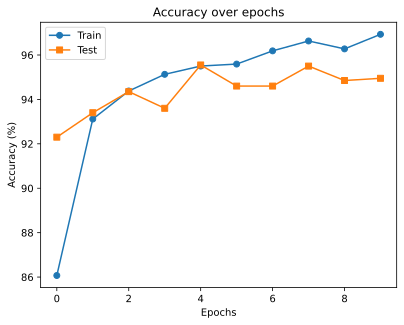

In [ ]:
# Run the model without changing the weights; this will be the baseline performance.
# Notice the model creation is outside the function2train
net_base,lossfun,optimizer = createTheMNISTNet()
trainAcc_base,testAcc_base,losses,net_base = function2trainTheModel(net_base,lossfun,optimizer)

# plot the results
plt.plot(range(len(trainAcc_base)),trainAcc_base,'o-', range(len(testAcc_base)),testAcc_base ,'s-')
plt.legend(['Train','Test'])
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

[1.00000000e-04 1.61559810e-04 2.61015722e-04 4.21696503e-04
 6.81292069e-04 1.10069417e-03 1.77827941e-03 2.87298483e-03
 4.64158883e-03 7.49894209e-03 1.21152766e-02 1.95734178e-02
 3.16227766e-02 5.10896977e-02 8.25404185e-02 1.33352143e-01
 2.15443469e-01 3.48070059e-01 5.62341325e-01 9.08517576e-01
 1.46779927e+00 2.37137371e+00 3.83118685e+00 6.18965819e+00
 1.00000000e+01]


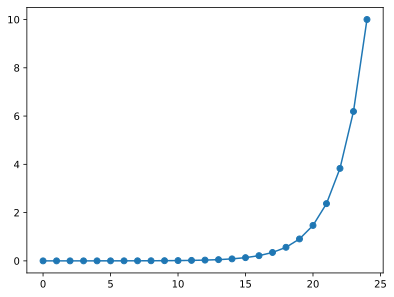

In [ ]:
log_dist = np.logspace(np.log10(.0001), np.log10(10), num = 25)
print(log_dist)
plt.plot(log_dist, "o-")
plt.show()

[1.0000000e-04 4.1676250e-01 8.3342500e-01 1.2500875e+00 1.6667500e+00
 2.0834125e+00 2.5000750e+00 2.9167375e+00 3.3334000e+00 3.7500625e+00
 4.1667250e+00 4.5833875e+00 5.0000500e+00 5.4167125e+00 5.8333750e+00
 6.2500375e+00 6.6667000e+00 7.0833625e+00 7.5000250e+00 7.9166875e+00
 8.3333500e+00 8.7500125e+00 9.1666750e+00 9.5833375e+00 1.0000000e+01]


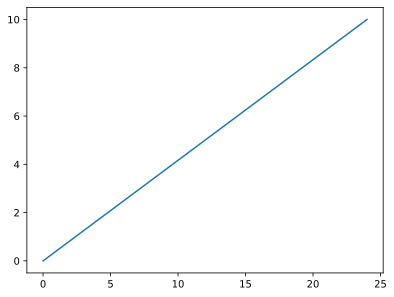

In [ ]:
lin_dist = np.linspace(.0001, 10, 25)
print(lin_dist)
plt.plot(lin_dist)
plt.show()

# Set all the weights of gaussian distribution

In [ ]:
torch.cat((torch.tensor([1]),(torch.tensor([1,2,3,4,4,5,5]))), 0)

RuntimeError: zero-dimensional tensor (at position 0) cannot be concatenated

In [ ]:
torch.normal(0, 10, size=(1, 10)).flatten()+torch.normal(0, 10, size=(1, 10))[0].flatten()

tensor([-10.4399,  -4.2774,   8.2854,   7.7928,  24.4802,  10.9318,  25.7983,
         11.6374, -12.7836,  -7.5132])

In [ ]:
results=[]

In [ ]:
i = 0
for std in log_dist :
  net_custom_weight,lossfun,optimizer = createTheMNISTNet()
  for p in net_custom_weight.named_parameters():
    layer_weights = torch.normal(0, std, size=(p[1].data.shape)).float()
    p[1].data = layer_weights
  trainAcc,testAcc,losses,net_custom_weight = function2trainTheModel(net_custom_weight,lossfun,optimizer)
  uncat_weights = []
  for param in net_custom_weight.parameters():
    uncat_weights.append(param.view(-1))
  weights = torch.cat(uncat_weights).detach()
  data ={
      "id": i,
      "accuracy" : testAcc[-3:],
      "weights" : weights,
      "std" : std
  }
  results.append(data)
  i+=1

In [ ]:
log_dist

array([1.00000000e-04, 1.61559810e-04, 2.61015722e-04, 4.21696503e-04,
       6.81292069e-04, 1.10069417e-03, 1.77827941e-03, 2.87298483e-03,
       4.64158883e-03, 7.49894209e-03, 1.21152766e-02, 1.95734178e-02,
       3.16227766e-02, 5.10896977e-02, 8.25404185e-02, 1.33352143e-01,
       2.15443469e-01, 3.48070059e-01, 5.62341325e-01, 9.08517576e-01,
       1.46779927e+00, 2.37137371e+00, 3.83118685e+00, 6.18965819e+00,
       1.00000000e+01])

Text(0, 0.5, 'stdv for weight initialization')

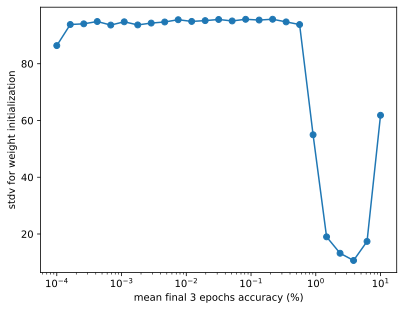

In [ ]:
plt.plot(log_dist, [np.mean(i["accuracy"]) for i in results][6:], "o-")
plt.xscale('log')
plt.xlabel("mean final 3 epochs accuracy (%)")
plt.ylabel("stdv for weight initialization")


In [ ]:
for idx, i in enumerate(results) :
  y, x = np.histogram(i["weights"].detach().numpy(), 80)
  new_x = (x[1:]+x[:-1])/2
  i["histdata"] = [new_x, y]

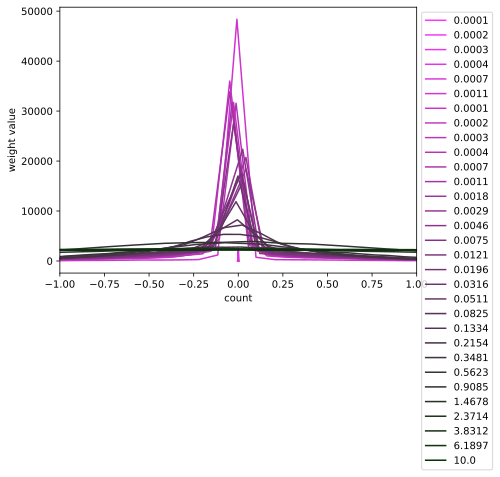

In [ ]:
for i in range(len(results)):
  plt.plot(results[i]["histdata"][0], results[i]["histdata"][1], color=[1-i/len(results),.2,1-i/len(results)])

plt.xlim(-1,1)
plt.xlabel("count")
plt.ylabel("weight value")
plt.legend(np.round([i["std"] for i in results],4),bbox_to_anchor=(1,1),loc='upper left')